In [1]:
import torch 
import torchvision 
import numpy as np

import os
import pandas as pd
import albumentations as A
import albumentations.pytorch
import cv2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# import torch.nn.functional as F

import sys
sys.path.append('../')
from dataset import val_transforms, CDataset

In [2]:
import easydict 
args = easydict.EasyDict({ "batch_size": 256, 
                          "epochs": 30, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':0,
                          'workers':16,
                         'print_freq':2000,
                          'ratio':0.2,
                         'saved_dir':'../trained_models/resnet/checkpoint.pt'})

In [3]:
# make saved dir
from pathlib import Path
path = Path(args.saved_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "3"  # Set the GPUs 2 and 3 to use

In [5]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
# device = torch.device('cpu')
# device = torch.device('cuda')
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

1
cuda:0


In [6]:
IMAGE_SIZE = 256
from augment import HEColorAugment
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
    A.OneOf([
        A.HorizontalFlip(p=.8),
        A.VerticalFlip(p=.8),
        A.RandomRotate90(p=.8)]
    ),
#     A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=[0.95,1.05],ratio=[0.95,1.05],p=0.5),
    A.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=.8),
#     HEColorAugment(sigma1=0.2, sigma2=.2, theta1=1., theta2=1., theta3=1., p=.8),
], p=1.0) 

In [7]:
import albumentations as A
import albumentations.pytorch
import cv2
from augment import HEColorAugment, rgb_to_sda

class CDataset(Dataset):
    def __init__(self, df, defaultpath='/home/beomgon/Dataset/new_patches/', transform=None):
        self.df = df
        self.transform = transform
        self.dir = defaultpath

    def __len__(self):
        return len(self.df)   

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 4]
#         print(pid)

        image = cv2.imread(self.dir + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = (image.astype(np.float32)-128.)/128.
        
#         if image is uint8, normalization by 255 is done automatically by albumebtation(ToTensor method)
        if self.transform:
            timage = self.transform(image=image)
            image = timage['image']
            
#         image = rgb_to_sda(image)
        
        image =  torch.tensor(image, dtype=torch.float32)/255.
        #image = (torch.tensor(image, dtype=torch.float32)-128)/128
        image = image.permute(2,0,1)
            
        label = self.df.iloc[idx, 5]
        return image, label, path

In [8]:
train_df = pd.read_csv('../dataframe/train_New_Colon_df.csv')
train_dataset = CDataset(train_df, defaultpath='/home/beomgon/pytorch/seegene/new_patches/', 
                         transform=train_transforms)

val_df = pd.read_csv('../dataframe/val_New_Colon_df.csv')
val_dataset = CDataset(val_df, defaultpath='/home/beomgon/pytorch/seegene/new_patches/',
                       transform=val_transforms)  

test_df = pd.read_csv('../dataframe/test_New_Colon_df.csv')
test_dataset = CDataset(test_df, defaultpath='/home/beomgon/pytorch/seegene/new_patches/',
                        transform=val_transforms)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(95804, 6)
(38679, 6)
(22782, 6)


In [9]:
image, label, path = next(iter(train_dataset))
# image

In [10]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)


In [11]:
images, labels, paths = next(iter(train_loader))
images.shape

torch.Size([256, 3, 256, 256])

In [12]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
# model = models.densenet201(pretrained=True)
# model.fc.out_features = 3
model.fc = nn.Linear(512, 3)
# model = nn.DataParallel(model)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.01)
# optimizer = torch.optim.SGD(
#        params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
# optimizer = torch.optim.SGD(params, lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], 
                                                    gamma=0.2)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
criterion = nn.CrossEntropyLoss().to(device)

In [13]:
torch.abs(torch.matmul(model.fc.weight, model.fc.weight.T) - 0.3*torch.eye(3, device='cuda')).mean()
# torch.abs(torch.matmul(model.module.fc.weight, model.module.fc.weight.T) - 0.3*torch.eye(3, device='cuda')).mean()

tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>)

In [14]:
torch.matmul(model.fc.weight, model.fc.weight.T) - 0.3*torch.eye(3, device='cuda')
# torch.matmul(model.module.fc.weight, model.module.fc.weight.T) - 0.3*torch.eye(3, device='cuda')

tensor([[0.0175, 0.0081, 0.0189],
        [0.0081, 0.0343, 0.0079],
        [0.0189, 0.0079, 0.0362]], device='cuda:0', grad_fn=<SubBackward0>)

In [15]:
model.fc
# model.module.fc

Linear(in_features=512, out_features=3, bias=True)

In [16]:
from main import *
# def train(train_loader, model, criterion, optimizer, epoch, args):
#     batch_time = AverageMeter('Time', ':6.3f')
#     data_time = AverageMeter('Data', ':6.3f')
#     losses = AverageMeter('Loss', ':.4e')
#     top1 = AverageMeter('Acc@1', ':6.2f')
#     progress = ProgressMeter(
#         len(train_loader),
#         [batch_time, data_time, losses, top1],
#         prefix="Epoch: [{}]".format(epoch))

#     # switch to train mode
#     model.train()

#     end = time.time()
#     for i, (images, targets, _) in enumerate(train_loader):
#         # measure data loading time
#         data_time.update(time.time() - end)

#         if args.gpu is not None:
#             images = images.cuda(args.gpu, non_blocking=True)
#         if torch.cuda.is_available():
#             targets = targets.cuda(args.gpu, non_blocking=True)

#         # compute output
#         output = model(images)
#         loss = criterion(output, targets)
#         fc_loss = torch.abs(torch.matmul(model.fc.weight, model.fc.weight.T) - 0.3*torch.eye(3, device='cuda')).mean()

#         # measure accuracy and record loss
#         acc1 = accuracy(output, targets)
#         losses.update(loss.item(), images.size(0))
#         top1.update(acc1[0], images.size(0))
        
#         loss += args.ratio*fc_loss

#         # compute gradient and do SGD step
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if i % args.print_freq == 0:
#             progress.display(i)
            
#     return losses.avg

In [17]:
ratio = [0., 0.05, 0.1, 0.2, 0.3, 0.4]
acc_list = []
test_acc = []

for num in range(len(ratio)) :
    args.saved_dir = '../trained_models/resnet/hsv/colon' + str(num) + '/checkpoint.pt'
    path = Path(args.saved_dir.split('checkpoint')[0])
    path.mkdir(parents=True, exist_ok=True)  
#     args.ratio = ratio[num]
    
    train_transforms = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
        A.OneOf([
            A.HorizontalFlip(p=.8),
            A.VerticalFlip(p=.8),
            A.RandomRotate90(p=.8)]
        ),
    #     A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=[0.95,1.05],ratio=[0.95,1.05],p=0.5),
        A.transforms.ColorJitter(brightness=ratio[num], contrast=ratio[num], saturation=ratio[num], hue=ratio[num], p=.8),
    #     HEColorAugment(sigma1=0.2, sigma2=.2, theta1=1., theta2=1., theta3=1., p=.8),
    ], p=1.0)     
    
    train_df = pd.read_csv('../dataframe/train_New_Colon_df.csv')
    train_dataset = CDataset(train_df, defaultpath='/home/beomgon/pytorch/seegene/new_patches/', 
                             transform=train_transforms)    
    
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                              shuffle=True, num_workers=args.workers)    
    
    model = models.resnet18(pretrained=True)
    # model.fc.out_features = 3
    model.fc = nn.Linear(512, 3)
#     model = nn.DataParallel(model)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.01)
    # optimizer = torch.optim.SGD(
    #        params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], 
                                                        gamma=0.2)
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    criterion = nn.CrossEntropyLoss().to(device)
    # print(model.fc.weight.shape)    
    
    best_acc1 = 0
    acc1 = 0
    train_loss = []
    val_acc = []

    for epoch in range(args.epochs):
        losses = train(train_loader, model, criterion, optimizer, epoch, args)
        scheduler.step()

        # evaluate after every epoch
        acc1 = validate(val_loader, model, criterion, args)   
        val_acc.append(acc1.item())

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1) 

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.saved_dir)   
        
    checkpoint = torch.load(args.saved_dir)
    model.load_state_dict(checkpoint['state_dict'])
    acc1 = validate(test_loader, model, criterion, args)    
    print('************* test number {} ratio {} acc{} *************'.format(num, ratio[num], acc1))    
    acc_list.append(val_acc)    
    test_acc.append(acc1)
    

Epoch: [0][  0/375]	Time 27.275 (27.275)	Data 10.717 (10.717)	Loss 1.0974e+00 (1.0974e+00)	Acc@1  43.75 ( 43.75)
Test: [  0/152]	Time 10.522 (10.522)	Loss 6.1844e+00 (6.1844e+00)	Acc@1  60.55 ( 60.55)
 * Acc@1 64.601
Epoch: [1][  0/375]	Time  2.186 ( 2.186)	Data  1.988 ( 1.988)	Loss 1.5838e-01 (1.5838e-01)	Acc@1  94.14 ( 94.14)
Test: [  0/152]	Time  2.042 ( 2.042)	Loss 1.9397e+00 (1.9397e+00)	Acc@1  60.55 ( 60.55)
 * Acc@1 64.226
Epoch: [2][  0/375]	Time  1.933 ( 1.933)	Data  1.737 ( 1.737)	Loss 1.2338e-01 (1.2338e-01)	Acc@1  95.31 ( 95.31)
Test: [  0/152]	Time  2.059 ( 2.059)	Loss 9.8720e-01 (9.8720e-01)	Acc@1  70.70 ( 70.70)
 * Acc@1 71.742
Epoch: [3][  0/375]	Time  1.941 ( 1.941)	Data  1.731 ( 1.731)	Loss 1.3195e-01 (1.3195e-01)	Acc@1  94.92 ( 94.92)
Test: [  0/152]	Time  2.023 ( 2.023)	Loss 6.9087e-01 (6.9087e-01)	Acc@1  72.66 ( 72.66)
 * Acc@1 71.832
Epoch: [4][  0/375]	Time  2.081 ( 2.081)	Data  1.876 ( 1.876)	Loss 2.0202e-01 (2.0202e-01)	Acc@1  92.97 ( 92.97)
Test: [  0/152]	Tim

[0.0, 0.05, 0.1, 0.2, 0.3, 0.4]


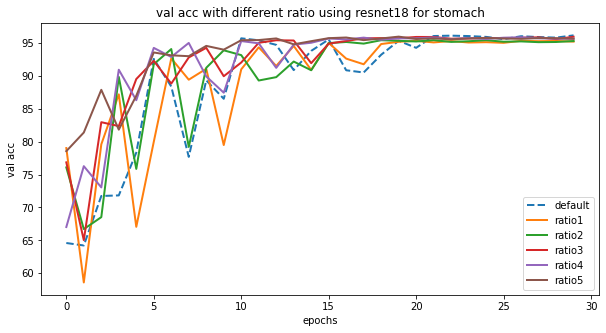

[tensor(96.8835, device='cuda:0'), tensor(96.3173, device='cuda:0'), tensor(95.6369, device='cuda:0'), tensor(95.8476, device='cuda:0'), tensor(95.4262, device='cuda:0'), tensor(95.3911, device='cuda:0')]


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(args.epochs)
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2
plt.plot(epochs, acc_list[0], linestyle='--')
plt.plot(epochs, acc_list[1])
plt.plot(epochs, acc_list[2])
plt.plot(epochs, acc_list[3])
plt.plot(epochs, acc_list[4])
plt.plot(epochs, acc_list[5])
plt.legend(['default', 'ratio1', 'ratio2', 'ratio3', 'ratio4', 'ratio5'])
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.title('val acc with different ratio using resnet18 for stomach')
print(ratio)
# plt.axis([10, 30, 88, 94])
plt.show()
print(test_acc)

In [19]:
for i in acc_list :
    print(i)

[64.60094451904297, 64.22606658935547, 71.74176788330078, 71.83226013183594, 78.3293228149414, 92.56702423095703, 88.36836242675781, 77.68297576904297, 89.30944061279297, 86.50947570800781, 95.6927490234375, 95.3902587890625, 94.69738006591797, 90.8632583618164, 93.78473663330078, 95.5169448852539, 90.8399887084961, 90.50130462646484, 93.200439453125, 95.3152847290039, 94.24752044677734, 96.04177856445312, 96.0960693359375, 96.03660583496094, 95.90992736816406, 95.56607055664062, 96.01075744628906, 95.88148498535156, 95.79875183105469, 96.14260864257812]
[79.01962280273438, 58.61061477661133, 79.58582305908203, 87.18167114257812, 67.05706024169922, 79.97362518310547, 92.63941192626953, 89.40768432617188, 91.0649185180664, 79.47982025146484, 90.97959899902344, 94.32250213623047, 91.48892211914062, 94.5370864868164, 90.88652801513672, 94.99469757080078, 92.60839080810547, 91.75004577636719, 94.82406616210938, 95.16791534423828, 95.30753326416016, 95.06967163085938, 95.27909088134766, 95.